## Feature Similarity Between Asian Elephants - 

### Using:

### Triplet Loss

In [1]:
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os
from torchvision import models
import csv
 
%matplotlib inline


### Helper Functions

In [2]:
## visualization helper
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    image = np.transpose(npimg,(1,2,0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.show() 
        
def visualize_loss(epochs, loss):
    plt.plot(range(epochs),loss)
    plt.show()
    
    
class RunningAverage(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

## Configuration Of Triplets

In [3]:
class Config():
    train_dir = "/share/jproject/fg508/mchivuku/datasets/asian_elephant/models/baseline-data/train"
    val_dir = "/share/jproject/fg508/mchivuku/datasets/asian_elephant/models/baseline-data/val/"
    test_dir = "/share/jproject/fg508/mchivuku/datasets/asian_elephant/models/metafgnet/test/New_test_Photos"
    batch_size = 128
    nepochs = 100
    learning_rate = 0.001
    num_classes = 14
    test_freq = 20
    n_train_triplets = 50000
    n_test_triplets = 100
    n_val_triplets = 1000
        
        
print(Config.train_dir)      

/share/jproject/fg508/mchivuku/datasets/asian_elephant/models/baseline-data/train


### Dataloaders - Build triplets

In [59]:
class AsianElephantTripletDataset(Dataset):
    def __init__(self, n_train_triplets, n_test_triplets, train=True, transform = None, target_transform = None):
        
        self.transform = transform
        self.train = train
        
        
        if self.train:
            self.n_train_triplets = n_train_triplets
            ## Train and Validation
            train_folder = dset.ImageFolder(root=Config.train_dir)
            self.train_imgs, self.labels = list(map(lambda x: x[0],train_folder.imgs)),list(map(lambda x: x[1],train_folder.imgs))    
            
            self.train_triplet_file = "train_triplets.txt"
            
            '''val_folder = dset.ImageFolder(root = Config.val_dir)
            self.val_imgs, self.val_labels = list(map(lambda x: x[0],val_folder.imgs)),list(map(lambda x: x[1],val_folder.imgs)) 
            self.val_triplet_file = "val_triplets.txt"
            
            self.make_triplet_list(n_train_triplets, n_val_triplets)
            
            ## Train Triplets, Val triplets
            triplets = []
            for line in open(self.train_triplet_file):
                triplets.append((int(line.split()[0]), int(line.split()[1]), int(line.split()[2]))) # anchor, close, far
            self.triplets_train = triplets
            
            
            val_triplets = []
            for line in open(self.val_triplet_file):
                val_triplets.append((int(line.split()[0]), int(line.split()[1]), int(line.split()[2]))) # anchor, close, far
            self.triplets_val = val_triplets
            '''
            
            ## Train Triplets
            self.make_triplet_list()
            triplets = []
            for line in open(self.train_triplet_file):
                triplets.append((int(line.split()[0]), int(line.split()[1]), int(line.split()[2]))) # anchor, close, far
            self.triplets_train = triplets
            
        else:
            self.n_test_triplets = n_test_triplets
            self.test_triplet_file = "test_triplets.txt"
            test_folder = dset.ImageFolder(root=Config.test_dir)
            self.test_imgs, self.test_labels = list(map(lambda x: x[0],test_folder.imgs)),list(map(lambda x: x[1],test_folder.imgs))    
            self.make_triplet_list()
           
            
            triplets = []
            for line in open(self.test_triplet_file):
                triplets.append((int(line.split()[0]), int(line.split()[1]), int(line.split()[2]))) # anchor, close, far
            self.triplets_test = triplets
            
            
            
    def make_triplet_list(self):
        
        
        if self.train:
            filename = self.train_triplet_file
            ntriplets = self.n_train_triplets
            labels  = (self.labels)
            
        else:
            filename = self.test_triplet_file
            ntriplets = self.n_test_triplets
            labels = (self.test_labels)
        triplets = []
        
        labels = np.array(labels)
        
        classes = np.unique(labels)
        
        for i in range(ntriplets):
            
            ## Pick one random class for anchor:
            anchor_class = np.random.randint(0,Config.num_classes) if self.train else np.random.choice(classes,size=1)
            
            [idx_A,idx_P] = np.random.choice(np.where(labels==anchor_class)[0],size=2,replace=False)
            
            ## Pick negative class
            idx_N = np.random.choice(np.where(labels!=anchor_class)[0], size=1, replace=True)
            triplets.append([int(idx_A), int(idx_P), int(idx_N)])           

        with open(filename,"w") as f:
            writer = csv.writer(f, delimiter=' ')
            writer.writerows(triplets)
            
        print('Done!')
        
        
    ## Get Item
    def __getitem__(self, index):
        if self.train:
            idx1, idx2, idx3 = self.triplets_train[index]
            img1, img2, img3 = self.train_imgs[idx1], self.train_imgs[idx2], self.train_imgs[idx3]
        else:
            idx1, idx2, idx3 = self.triplets_test[index]
            img1, img2, img3 = self.test_imgs[idx1], self.test_imgs[idx2], self.test_imgs[idx3]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img1 = Image.open(img1)
        img2 = Image.open(img2)
        img3 = Image.open(img3)

        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)

        return img1, img2, img3
        
        
    def __len__(self):
        if self.train:
            return len(self.triplets_train)
        else:
            return len(self.triplets_test)
        
        
        
        

In [60]:
kwargs = {'num_workers': 2, 'pin_memory': True} if torch.cuda.is_available() else {}
## Dataloaders
normalize = torchvision.transforms.Normalize(
mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

data_transforms = {
        'train': torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        normalize,
        ]),
     
      'test': torchvision.transforms.Compose([
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
            normalize,
        ])

    }
train_loader = torch.utils.data.DataLoader(AsianElephantTripletDataset(Config.n_train_triplets, Config.n_test_triplets, True, data_transforms["train"]), batch_size=Config.batch_size, shuffle=True, **kwargs)

Done!


In [61]:
test_loader = torch.utils.data.DataLoader(AsianElephantTripletDataset(Config.n_train_triplets, Config.n_test_triplets, False, data_transforms["test"]),batch_size=Config.batch_size, shuffle=True, **kwargs)

Done!


In [62]:
print(f" No of train imgs: {len(train_loader)}, No of test img:{len(test_loader)}")

 No of train imgs: 391, No of test img:1


## Visualize Some Examples

Done!


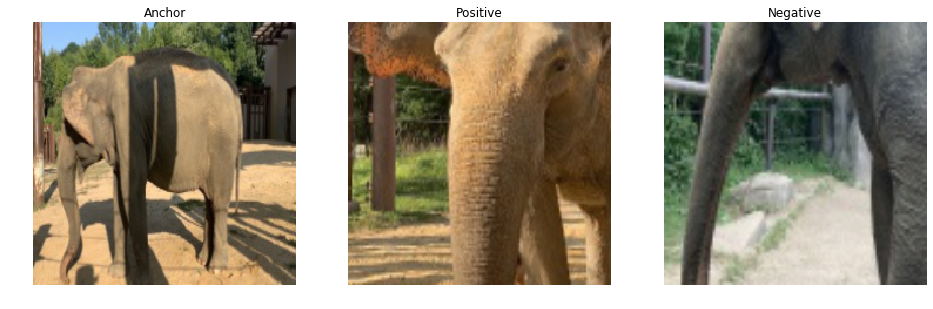

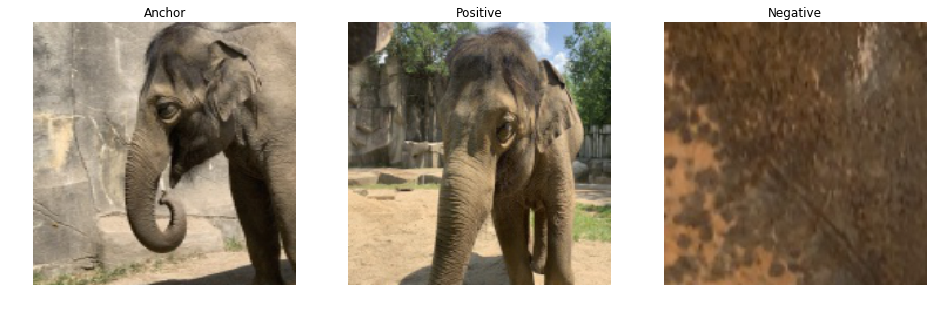

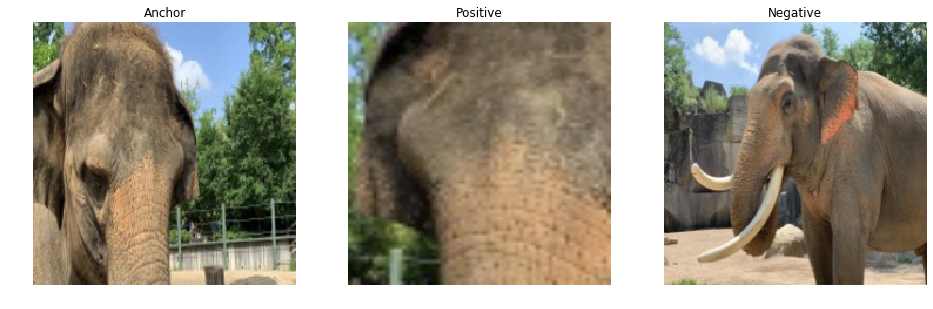

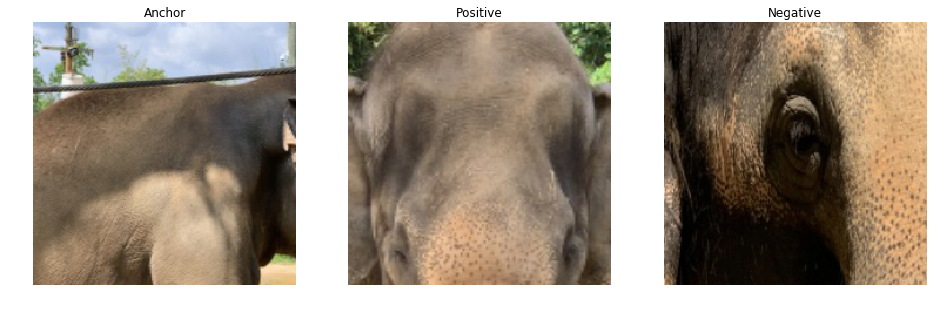

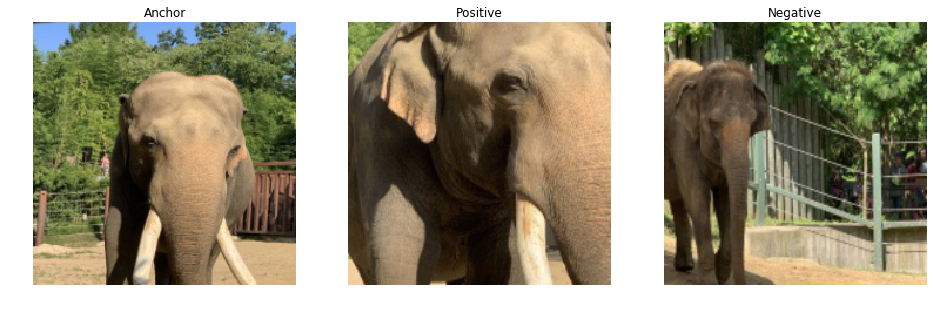

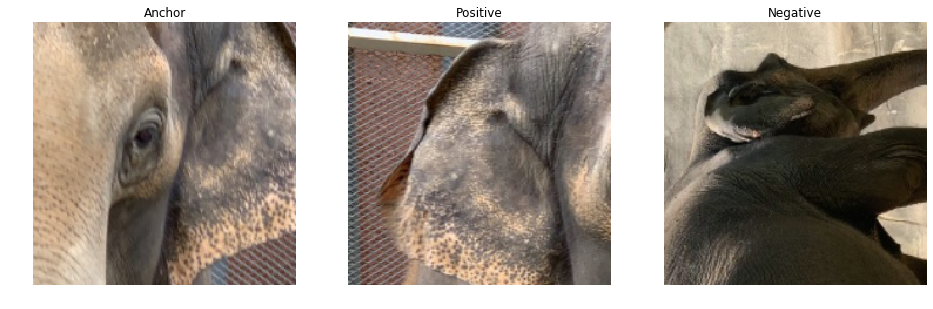

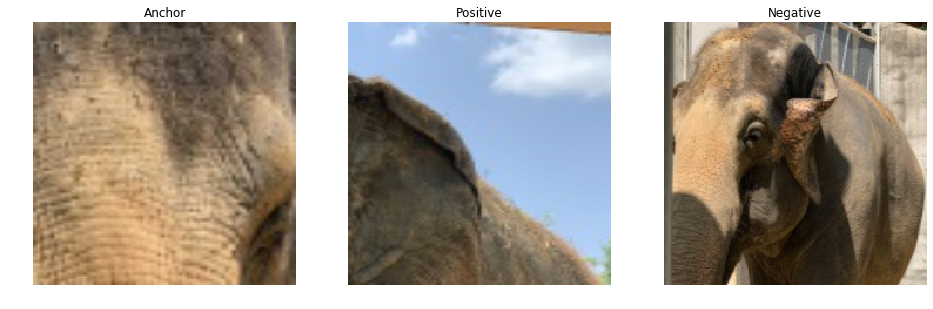

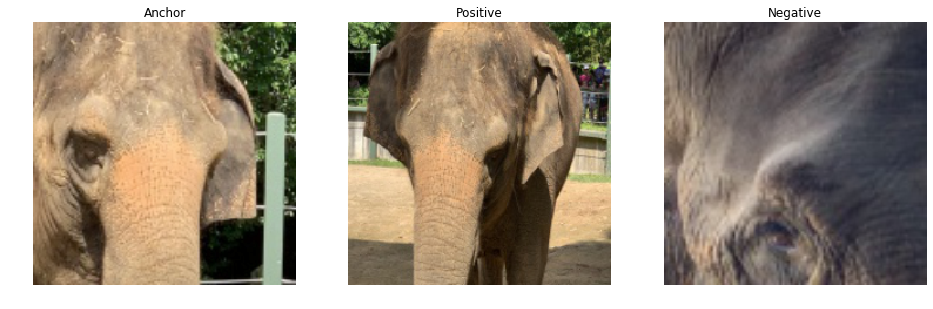

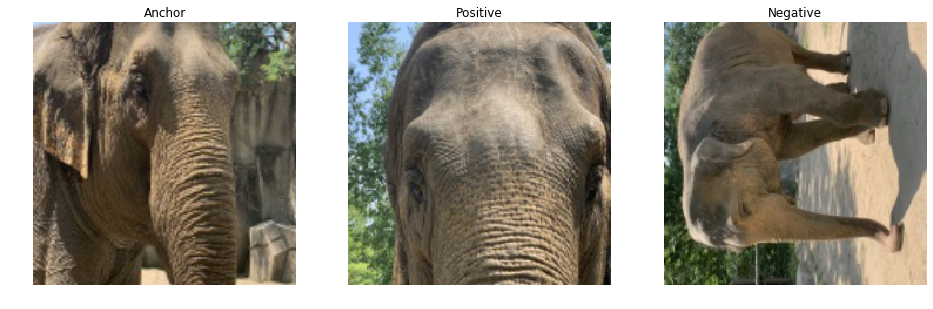

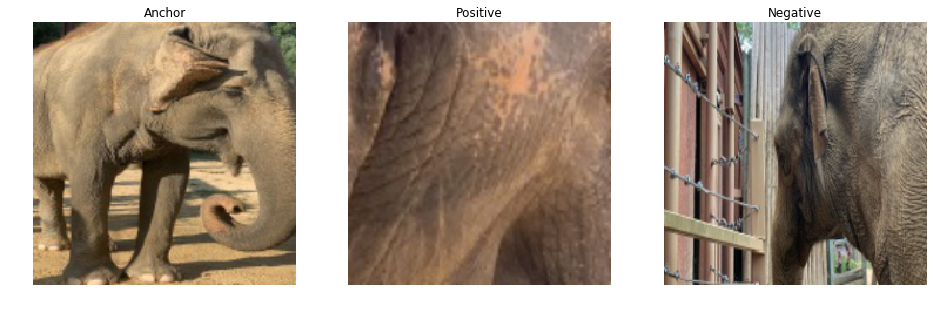

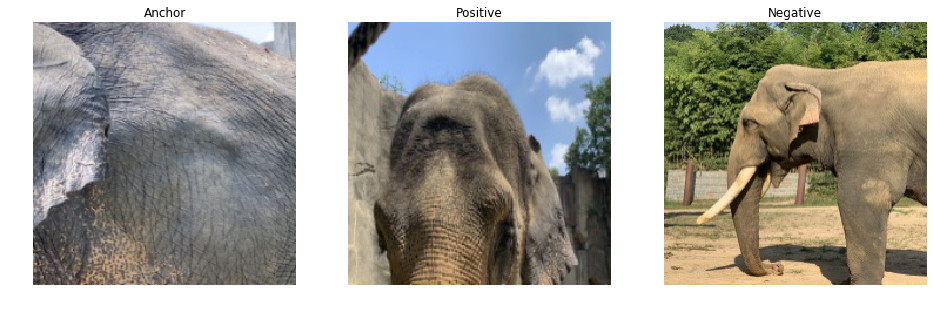

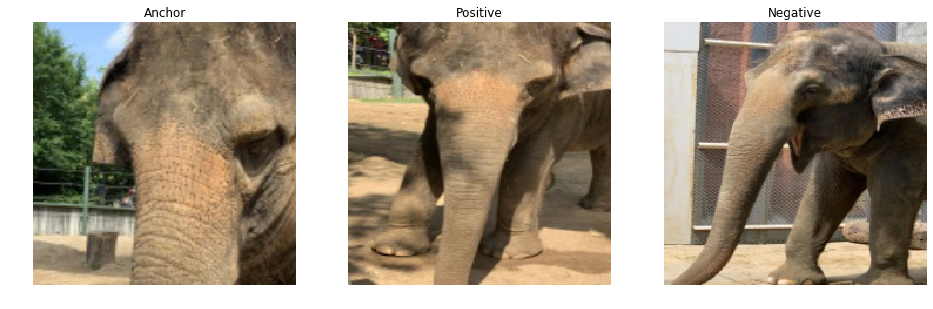

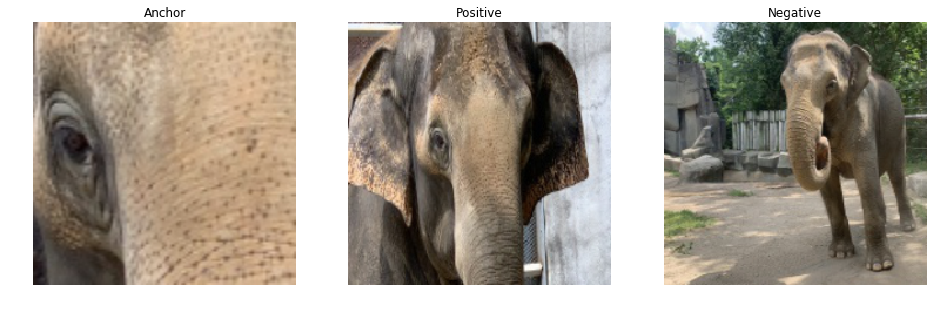

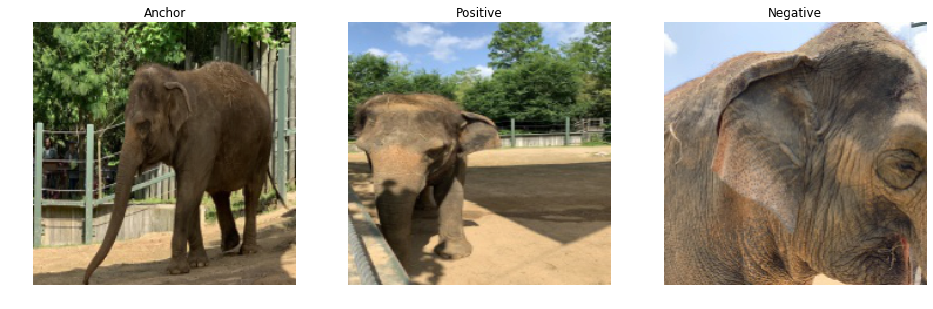

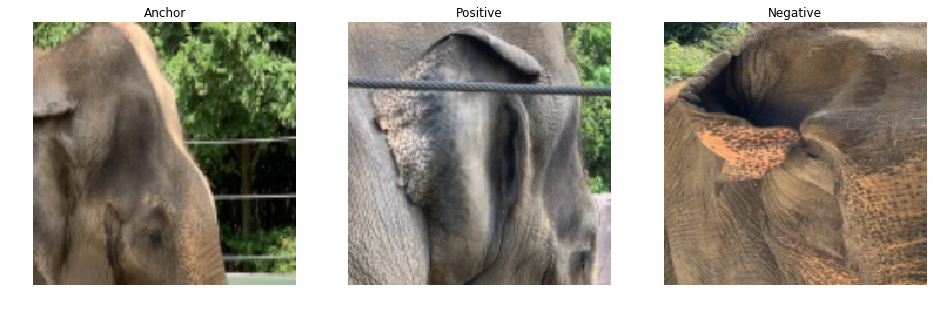

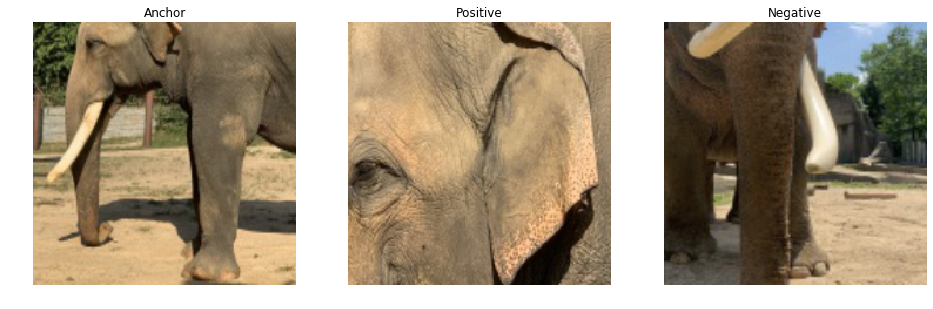

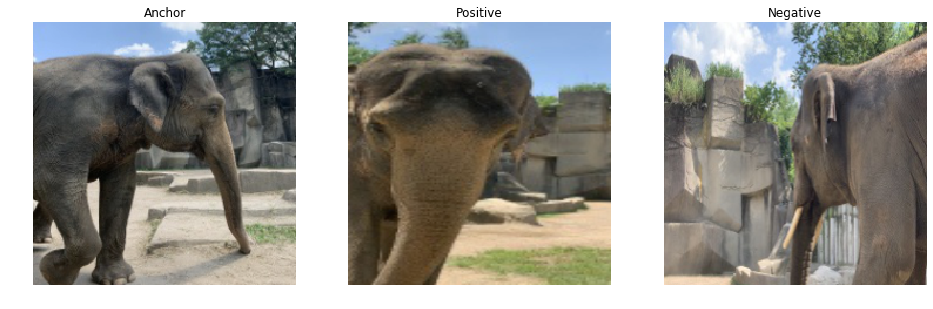

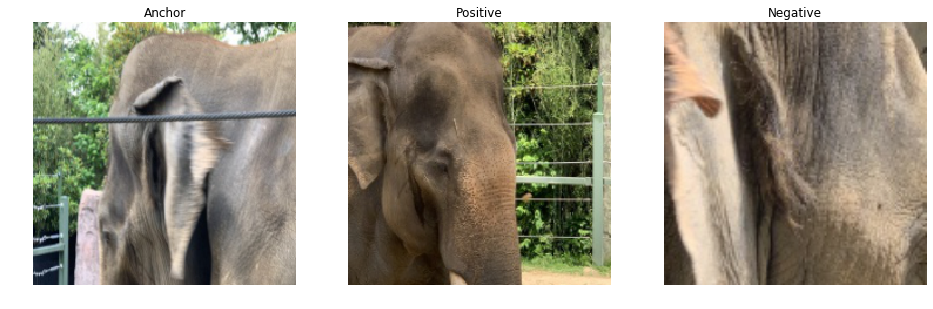

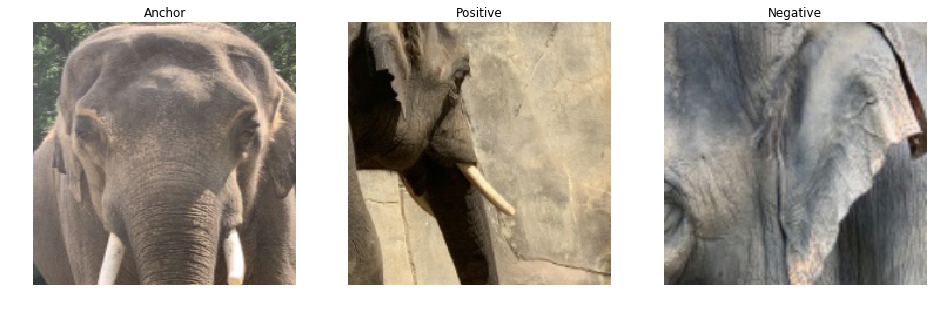

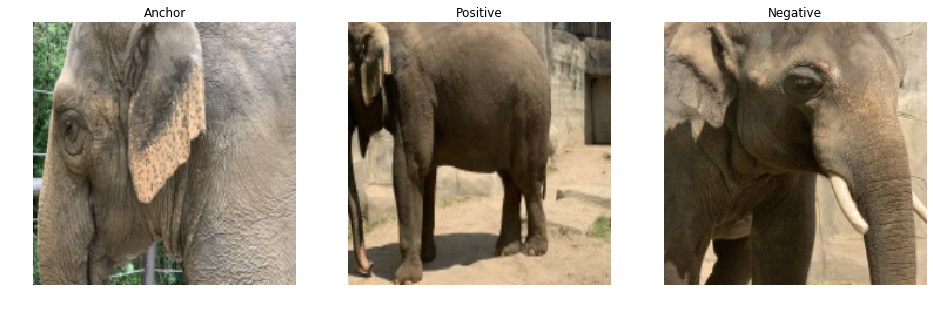

In [79]:
viz_loader =  torch.utils.data.DataLoader(AsianElephantTripletDataset(Config.n_train_triplets, Config.n_test_triplets, True, data_transforms["train"]), batch_size=1, shuffle=True, **kwargs)
dataiter = iter(viz_loader)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

nrows = 20
ncols = 3
labels = ["Anchor", "Positive", "Negative"]

for row in range(nrows):
    example_batch = next(dataiter)
    fig=plt.figure(figsize=(16,10))
    for i in range(ncols):
        subplot = fig.add_subplot(1,3,i+1)
        plt.axis("off")
        
        image = np.transpose(example_batch[i][0].numpy(),(1,2,0))
        # Undo preprocessing
        image = std * image + mean
        image = np.clip(image, 0, 1)
        plt.imshow(image)
    
        subplot.title.set_text(labels[i])

### Build Model

In [80]:
import copy
import math
__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=14):
        
        self.inplanes = 64
        
        super(ResNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        
        return x

In [81]:
class AsianElephantSiemeseNetworkTripletLoss(nn.Module):
    def __init__(self,resnet_conv,convout_dimension):
        super(AsianElephantSiemeseNetwork,self).__init__()
        ## check with Shujon
        self.resnet_conv = resnet_conv
        self.convout_dimension = convout_dimension
        
    def forward(self, x):
        x = self.resnet_conv(x)
        return x.view(-1,self.convout_dimension)



### Triplet Loss

L=max(d(A,P)−d(A,N)+margin,0)

In [ ]:
class TripletLoss(torch.nn.Module):
    """
    Contrastive Loss
    """
    def __init__(self, margin = 0.2):
        super(TripletLoss,self).__init__()
        self.margin = margin
        if self.margin is None:  # use soft-margin
            self.Loss = nn.SoftMarginLoss()
        else:
            ## Euclidean norm
            self.Loss = nn.TripletMarginLoss(margin = margin, p = 2)
            
    def forward(self, encoded_anchor, encoded_pos, encoded_neg):
        ap_dist = torch.norm(encoded_anchor - encoded_pos, 2, dim = 1).view(-1)
        an_dist = torch.norm(encoded_anchor - encoded_neg, 2, dim = 1).view(-1)
        
        if self.margin is None:
               loss = self.Loss(an_dist - ap_dist, y)
        else:
            loss = self.Loss(encoded_anchor, encoded_pos, encoded_neg)
        
        return loss_contrastive